<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/CNN%20dist%20reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas-ta

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas_ta as ta
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.initializers import GlorotUniform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/eurusd_hour.csv")
print(df)

             Date   Time       BO       BH       BL       BC      BCh  \
0      2005-05-02  00:00  1.28520  1.28520  1.28400  1.28440 -0.00080   
1      2005-05-02  01:00  1.28440  1.28480  1.28390  1.28420 -0.00020   
2      2005-05-02  02:00  1.28430  1.28540  1.28410  1.28510  0.00080   
3      2005-05-02  03:00  1.28510  1.28590  1.28500  1.28510  0.00000   
4      2005-05-02  04:00  1.28520  1.28590  1.28490  1.28550  0.00030   
...           ...    ...      ...      ...      ...      ...      ...   
93079  2020-04-29  18:00  1.08620  1.08851  1.08611  1.08713  0.00093   
93080  2020-04-29  19:00  1.08711  1.08823  1.08659  1.08748  0.00037   
93081  2020-04-29  20:00  1.08747  1.08788  1.08691  1.08708 -0.00039   
93082  2020-04-29  21:00  1.08708  1.08740  1.08699  1.08714  0.00006   
93083  2020-04-29  22:00  1.08728  1.08760  1.08727  1.08743  0.00015   

            AO       AH       AL       AC      ACh  
0      1.28540  1.28540  1.28420  1.28460 -0.00080  
1      1.28460  1

In [5]:
Date = pd.DataFrame()
new = pd.DataFrame()

new['Date'] = pd.to_datetime(df['Date'])
new['Time'] = pd.to_datetime(df['Time'])

Date['day'] = new['Date'].dt.day
Date['month'] = new['Date'].dt.month
Date['weekday'] = new['Date'].dt.weekday
Date['hour_of_day'] = new['Time'].dt.hour

scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale each column individually
for column in Date.columns:
    Date[column] = scaler.fit_transform(Date[[column]])


print(Date.shape)

(93084, 4)


In [6]:
change = df['ACh']
change.name = 'change'
target = df['ACh'].shift(-3)
target.name = 'target'

combined_series = pd.concat([change, target,Date], axis=1)
combined_series = combined_series.dropna(axis=0)

target = combined_series.pop('target')
Change = combined_series

target = target.values

print(Change.shape)

(93081, 5)


In [7]:
def reshape_time_series(data, window_length, stride):
    num_windows = (len(data) - window_length) // stride + 1
    sliding_windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=(window_length,))
    reshaped_data = sliding_windows[:num_windows * stride:stride]

    return reshaped_data

In [8]:
def reshape_time_series_2(data, window_length, stride):
    # Calculate the number of windows
    num_windows = (len(data) - window_length) // stride + 1

    # Create sliding windows
    sliding_windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=(window_length, 5))

    # Reshape the data
    reshaped_data = sliding_windows[:num_windows * stride:stride]
    reshaped_data = reshaped_data.reshape((num_windows, window_length, 5))

    return reshaped_data

In [9]:

Change_win = reshape_time_series_2(Change,100,1)
np.set_printoptions(suppress=True)

# Get the desired shape from the second array
desired_shape = Change_win.shape[0]

# Slice the first array to match the desired shape
target_adju = target[:desired_shape]


print(target_adju.shape)
print(Change_win.shape)


(92982,)
(92982, 100, 5)


In [10]:
def my_dist(params):
    return tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

In [31]:
# Define a custom kernel constraint to limit precision
class PrecisionConstraint(tf.keras.constraints.Constraint):
    def __init__(self, precision=8):
        self.precision = precision

    def __call__(self, w):
        multiplier = tf.constant(10**self.precision, dtype=w.dtype)
        rounded = tf.round(w * multiplier) / multiplier
        return rounded


In [37]:
def custom_constraint(weight):
    small_weight_penalty = 0.0001  # Adjust the penalty value as needed
    large_weight_penalty = 0.0002  # Adjust the penalty value as needed

    # Apply penalty to small weights
    small_penalty = small_weight_penalty * K.mean(K.maximum(K.abs(weight) - 0.1, 0.0))

    # Apply penalty to large weights
    large_penalty = large_weight_penalty * K.mean(K.maximum(K.abs(weight) - 1.0, 0.0))

    return weight + small_penalty - large_penalty

In [46]:
def custom_regularizer(weight):
    small_weight_penalty = 0.0001  # Adjust the penalty value as needed
    large_weight_penalty = 0.0002  # Adjust the penalty value as needed
    mean_penalty = 0.0003  # Adjust the penalty value as needed

    # Apply penalty to small weights
    small_penalty = small_weight_penalty * K.mean(K.maximum(K.abs(weight) - 0.1, 0.0))

    # Apply penalty to large weights
    large_penalty = large_weight_penalty * K.mean(K.maximum(K.abs(weight) - 1.0, 0.0))

    # Apply penalty to mean of weights
    mean = K.mean(weight)
    mean_penalty = mean_penalty * K.abs(mean)

    return small_penalty - large_penalty + mean_penalty

In [65]:
def bimodal_regularizer(weight_matrix):
    peak1_mean = -1.0
    peak2_mean = 1.0
    peak_stddev = 0.1  # Adjust the standard deviation as needed
    mean_penalty = 0.001  # Adjust the penalty value as needed

    # Calculate the probability density of the weight values for each peak
    peak1_pdf = K.exp(-0.5 * K.square((weight_matrix - peak1_mean) / peak_stddev))
    peak2_pdf = K.exp(-0.5 * K.square((weight_matrix - peak2_mean) / peak_stddev))

    # Combine the probability densities of the two peaks
    bimodal_pdf = peak1_pdf + peak2_pdf

    # Calculate the negative log-likelihood as the regularization term
    regularization = -K.log(bimodal_pdf)

    # Calculate the mean of the weights
    mean = K.mean(weight_matrix)

    # Add penalty if the mean is far from zero
    mean_penalty_term = mean_penalty * K.square(mean)

    return regularization + mean_penalty_term

In [178]:
def bimodal_regularizer(scale=.000001):
    def regularizer(weights):
        mean = tf.reduce_mean(weights)
        std = tf.math.reduce_std(weights)
        weights_normalized = weights
        weights_distance = tf.abs(weights_normalized - tf.where(tf.less(weights_normalized, 0.0), -1.0, 1.0))
        penalty = tf.reduce_sum(weights_distance)
        return scale * penalty

    return regularizer

In [207]:
class NormalDistributionRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, scale=1e-2):
        self.scale = scale

    def __call__(self, weights):
        penalty = tf.reduce_mean(tf.abs(weights - 0.5))
        return self.scale * penalty

In [208]:
input_length = 100
input_channels = 5
dropout_rate = .2

model = tf.keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='LeakyReLU', input_shape=(input_length, input_channels), kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Flatten(),
    layers.Dropout(rate=dropout_rate),
    layers.Dense(units=128, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Dense(units=64, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Dense(units=2, activation='linear', kernel_initializer=GlorotUniform()),  # 2 units for mean and variance
    tfp.layers.DistributionLambda(my_dist)
])
def NLL(y_true, distr):
    return -distr.log_prob(y_true)



In [209]:
def negative_log_likelihood(y_true, y_pred):
  return -tf.reduce_mean(y_pred.log_prob(y_true))
model.compile(optimizer='adam', loss=negative_log_likelihood)

In [ ]:
num_epochs = 10000
model.fit(x=Change_win, y=target_adju,batch_size=64, epochs=num_epochs)

Epoch 1/10000
1453/1453 [==============================] - 39s 24ms/step - loss: -0.7023
Epoch 2/10000
1453/1453 [==============================] - 33s 23ms/step - loss: -0.8764
Epoch 3/10000
1453/1453 [==============================] - 33s 23ms/step - loss: -1.1458
Epoch 4/10000
1453/1453 [==============================] - 35s 24ms/step - loss: -1.0467
Epoch 5/10000
1453/1453 [==============================] - 35s 24ms/step - loss: -1.5390
Epoch 6/10000
1453/1453 [==============================] - 35s 24ms/step - loss: -1.3531
Epoch 7/10000
1453/1453 [==============================] - 33s 23ms/step - loss: -1.7241
Epoch 8/10000
1453/1453 [==============================] - 35s 24ms/step - loss: -1.6311
Epoch 9/10000
1453/1453 [==============================] - 36s 24ms/step - loss: -1.1032
Epoch 10/10000
1453/1453 [==============================] - 33s 23ms/step - loss: -1.8901
Epoch 11/10000
1453/1453 [==============================] - 34s 23ms/step - loss: -1.5612
Epoch 12/10000
1453

In [ ]:
pred = model.predict(Change_win)

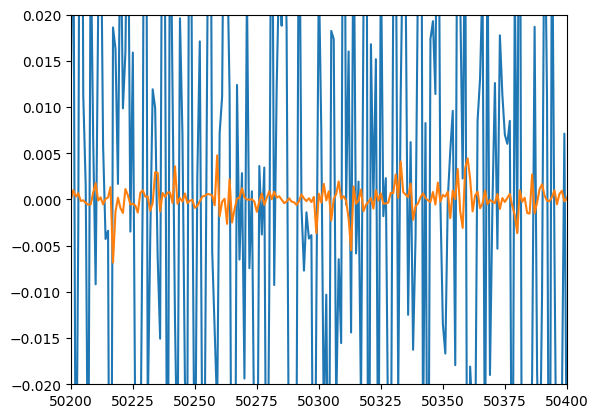

In [176]:
plt.plot(pred)
plt.xlim(50200,50400)
plt.ylim(-.02,.02)
plt.plot(target)

In [199]:
weights = model.get_weights()

[0.2745845  0.41839886 0.36604398 0.3292648  0.26550615 0.37033963
 0.29789868 0.32510164 0.40477318 0.43431798 0.2413134  0.2285555
 0.26874632 0.24438483 0.2832222  0.30396545 0.2698025  0.15507057
 0.34953445 0.41990438 0.26282522 0.37336332 0.30585638 0.14607589
 0.28121597 0.3771489  0.32986903 0.42685696 0.33332077 0.24208969
 0.32932314 0.22203009 0.4060808  0.18882376 0.22327794 0.27981484
 0.44848827 0.335163   0.37113616 0.1983797  0.27609026 0.3490423
 0.27491453 0.20134385 0.25073403 0.13580722 0.3881695  0.43782565
 0.29934597 0.34506503 0.28898007 0.36089477 0.37318397 0.35330248
 0.31269258 0.33374113 0.15626122 0.30359012 0.34307647 0.30233896
 0.20297132 0.22674608 0.28705934 0.23596337]


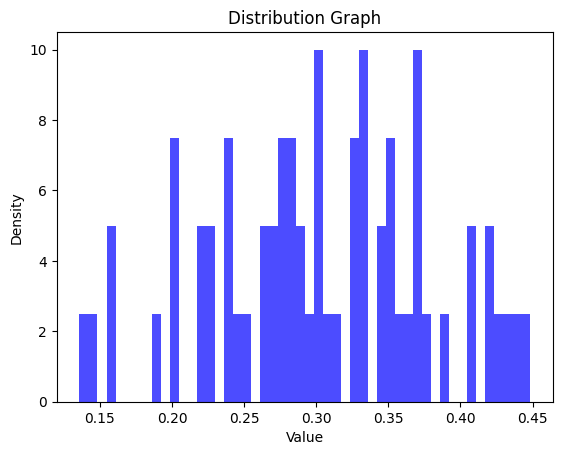

In [202]:
print(weights[0][1][0])
data = weights[0][1][0]
# Plot the distribution
plt.hist(data, bins=50, density=True, alpha=0.7, color='blue')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Graph')

# Show the plot
plt.show()